# Deconfounding Movie Revenues - Preliminary Results
This is the Pyro implementation of the Deconfounder from Blei-labs "Blessings of Multiple Causes" which investigates actor values by aiming to infer latent confounders that afffect casting and revenue of the movie. <br>

For example: In a James Bond movie, revenue is primarily driven by the actor who plays James Bond and the franchise value that Bond movies carry. Supporting roles like M and Q do not contribute much to revenue. This fact is not captured by traditional linear regression models which bias revenue towards these actors. <br>

The **deconfounder** debiases these predictions by correcting the regression coefficients of these actors and hence, brings the model closer to the actual value of actors to a movie and its revenue.

## Probabilistic PCA model:

<!-- ![Assumed Model](dag_probpca.jpg) -->


\begin{equation}
\mathbf{z}_{n} \stackrel{iid}{\sim} N(\mathbf{0}, \mathbf{I}_K) \\
\mathbf{w}_{n} \stackrel{iid}{\sim} N(\mathbf{0}, \mathbf{I}_K) \\
\mathbf{x}_n \mid \mathbf{z}_n
\sim Bernoulli(\mathbf{z}_n\mathbf{W})
\end{equation}

In [9]:
import numpy as np
import pandas as pd
import pyro
import torch
import torch.distributions.constraints as constraints
from scipy import sparse
from sklearn.model_selection import train_test_split
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
pyro.set_rng_seed(101)
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle

import warnings

warnings.filterwarnings('ignore')

In [10]:
class PPCA():
    def __init__(self, X, no_components=30, lr = 0.0005):
        self.X = torch.tensor(X.to_numpy(dtype = 'float32'))
        self.N = no_components
        self.len, self.dim = X.shape
        self.lr = lr
        self.inferred_z = None
    
    def model(self):
        # Parameters for w
        w_mean0 = torch.zeros([self.N, self.dim])
        w_std0 = torch.ones([self.N, self.dim])
        # Parameters for z
        z_mean0 = torch.zeros([self.len, self.N])
        z_std0 = torch.ones([self.len, self.N])
        w = pyro.sample("w", pyro.distributions.Normal(loc = w_mean0, 
                                                       scale = w_std0))
        z = pyro.sample("z", pyro.distributions.Normal(loc = z_mean0, 
                                                       scale = z_std0))
        linear_exp = torch.matmul(z, w)
        x = pyro.sample("x", pyro.distributions.Bernoulli(logits = linear_exp), obs = self.X)
    
    def guide(self):
        qw_mean = pyro.param("qw_mean", torch.zeros([self.N, self.dim]))
        qw_stddv = pyro.param("qw_stddv", torch.ones([self.N, self.dim]),
                             constraint=constraints.positive)

        qz_mean = pyro.param("qz_mean", torch.zeros([self.len, self.N]))
        qz_stddv = pyro.param("qz_stddv", torch.ones([self.len, self.N]),
                             constraint=constraints.positive)
        

        w = pyro.sample("w", pyro.distributions.Normal(loc = qw_mean, 
                                                       scale = qw_stddv))
        z = pyro.sample("z", pyro.distributions.Normal(loc = qz_mean, 
                                                       scale = qz_stddv))
        
    def fit(self, n_steps=2000):
        adam_params = {"lr": self.lr}
        optimizer = Adam(adam_params)
        svi = SVI(self.model, self.guide, optimizer, loss=Trace_ELBO())
        # do gradient steps
        for step in range(n_steps):
            svi.step()
            if step % 100 == 0:
                print('.', end='')
        
        self.qw_m = pyro.param("qw_mean")
        self.qw_s = pyro.param("qw_stddv")

        self.qz_m = pyro.param("qz_mean")
        self.qz_s = pyro.param("qz_stddv")
        
        self.inferred_z = pyro.sample("inf_z", pyro.distributions.Normal(loc = self.qz_m, 
                                                   scale = self.qz_s))
        
        
    def getLatentConfounders(self):
        return self.inferred_z
    
    def attachToData(self, df, filename=None, save=False):
        z = self.inferred_z.detach().numpy()
        z_cols = ["z"+str(i) for i in range(30)]
        df_z = pd.DataFrame(z, columns=z_cols)
        x_z = np.hstack((df.to_numpy(), df_z.to_numpy()))
        final = pd.DataFrame(x_z, columns = list(df.columns) + list(df_z.columns))
        if save:
            final.to_csv(filename, index=False, header=True)
        return final

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

class NNRegression():
    def __init__(self, X, Y, n_feature, n_hidden=1024, n_output=1, n_steps=500, lr=0.2):
        self.net = Net(n_feature=n_feature, n_hidden=n_hidden, n_output=1)
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=lr)
        self.loss_func = torch.nn.L1Loss()
        self.X = X
        self.Y = Y
        self.n_steps = n_steps
    
    def fit(self):
        for t in range(self.n_steps):
            prediction = self.net(self.X)
            self.loss = self.loss_func(prediction, self.Y) 
            self.optimizer.zero_grad()   # clear gradients for next train
            self.loss.backward()         # backpropagation, compute gradients
            self.optimizer.step()        # apply gradients
            if t%100 == 0:
                print("[iteration %04d] loss: %.4f" % (t + 1, self.loss.item()))
    
    def fit_predict(self, X, Y):
        self.X = X
        self.Y = Y
        self.fit()
        return self.score(X, Y)
    
    def predict(self, X_test):
        return self.net(X_test)
    
    def score(self, X_test, Y_test):
        Y_hat = self.predict(X_test)
        return mean_squared_error(Y_test.detach().numpy(), Y_hat.detach().numpy())

def plot(Y, Yhat, score=None):
    plt.plot(Y.detach().numpy(), Yhat.detach().numpy(), 'o')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    if not score == None:
        plt.title('MSE :' + str(score))
    else:
        plt.title('True v/s Predicted')
    plt.show()
    
def actorImpact(actor, data, Y, model):
    actor_data = data[data[actor]==1]
    actor_data[actor] = 0
    actor_data = actor_data.iloc[:, :-30]
    actor_y = Y[actor_data.index]
    actor_ppca = PPCA(actor_data)
    actor_ppca.fit(n_steps=2000)
    actor_data_conf = actor_ppca.attachToData(actor_data)
    print('\nConfouders generated.')
    actor_y_hat = model.predict(torch.tensor(actor_data_conf.to_numpy()).float())
    plot(torch.tensor(actor_y),actor_y_hat)
    actor_present = np.mean((actor_y * ss.scale_) + ss.mean_)
    actor_absent = np.mean((actor_y_hat.detach().numpy() * ss.scale_) + ss.mean_)
    impact = actor_absent - actor_present
    print('The causal effect of ' + actor + ' = ' + str(impact))

In [11]:
data = pd.read_csv('ohe_movies_confounders.csv')
y_data = pd.read_csv('ohe_movies.csv')
Y = y_data.iloc[:, 2].values
ss = StandardScaler()
Y = ss.fit_transform(Y.reshape(-1,1))
model = pickle.load(open('NNRegression.pickle', 'rb'))

....................
Confouders generated.


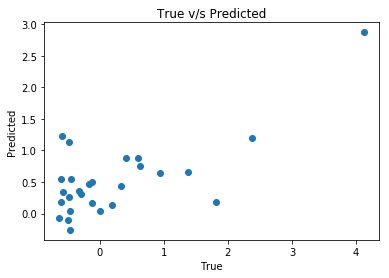

The causal effect of Ben Affleck = 56754192.82065046


In [4]:
actorImpact('Ben Affleck', data, Y, model)

....................
Confouders generated.


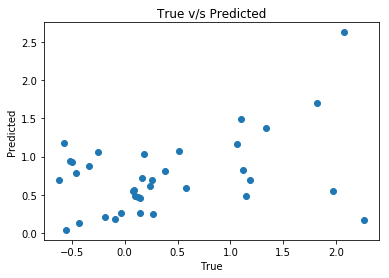

The causal effect of Brad Pitt = 66743067.83629504


In [4]:
actorImpact('Brad Pitt', data, Y, model)

....................
Confouders generated.


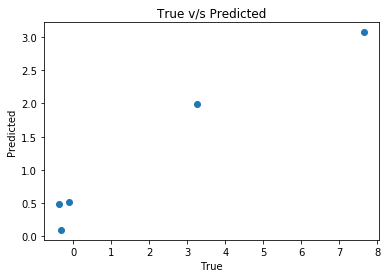

The causal effect of Cobie Smulders = -144551943.32368004


In [12]:
actorImpact('Cobie Smulders', data, Y, model)